# **Methanol Synthesis by Catalytic Hydrogenation of CO2**
<br>

## **1. Introduction**

This script aims to simulate a catalytic reactor design to perform the synthesis of methanol by hydrogenation of CO2. This simulations is based on the work of Gosh *et al.*, 2021.



## **2. Hypothesis about the system**

- gaseous phase is ideal
- stationary operation
- reactions follow a Langmuir-Hinshelwood mechanism, where the reactant must adsorve over the catalyst surface before reaction
- reference state is 25 °C and 1 bar
- methanol adsorption obver catalyst is negligible
- both single site and dual site approaches are tested
- enthalpy of adsorption is constant over the temperature range
- no pressure drop
- mass transfer resistances are negligible
- no radial dispersion (PBR approach)
- the catalyst suffers no desactivation over time
- only adiabatic approach is tested
- the feed contains only CO2 and H2
- a $In_2O_3$ catalyst is applied

## **3. Reactions considered in this system**

<br>

$$CO_{2(g)} + 3 H_{2(g)}\rightleftharpoons CH_3OH_{(g)} + H_2O_{(g)}$$

$$CO_{2(g)} + H_{2(g)} \rightleftharpoons CO_{(g)} + H_2O_{(g)}$$

$$CO_{2(g)} + 4 H_{2(g)}\rightleftharpoons CH_4{(g)} + 2 H_2O_{(g)}$$


## **4. Rate laws for Langmuir-Hinshelwood mechanism**

By following the Langmuir-Hinshelwood mechanism, the rate laws are given by equations below:

$$r_{CH_3OH}=\frac{k_1 \frac{\Bigg(P_{CO_2}P_{H_2}^3 - \frac{P_{CH_3OH}P_{H_2O}}{K_{eq, CH_3OH}}\Bigg)}{P_{H_2}^2}}{\text{Inhibition Term}}$$

<br>

$$r_{RWGS} = \frac{k_2 \frac{\Bigg(P_{CO_2}P_{H_2} - \frac{P_{CO} P_{H_2O}}{K_{eq, RWGS}}\Bigg)}{\sqrt{P_{H_2}}}}{\text{Inhibition Term}}$$

<br>

$$r_{CH4} = k_3\sqrt{P_{CO_2}} \sqrt{P_{H2}}\frac{\Bigg(1-\frac{P_{CH_4}P_{H_2O}^2}{P_{CO_2}P_{H_2}^4 K_{eq, CH_4}}\Bigg)}{\text{Inhibition Term}}$$

<br>

The expression for the inhibition term will depend on the approach, as follows:

<br>

$$\text{Inhibition Term} = (1+K_{CO_2}P_{CO_2}+\sqrt{K_{H2}P_{H2}})^2\text{ for the single-site approach}$$

<br>

$$\text{Inhibition Term} = (1+K_{CO_2}P_{CO_2})(1+\sqrt{K_{H2}P_{H2}})\text{ for the single-site approach}$$

<br>

Where: 
- $K_{eq,i}$ is the chemical equilibrium constant, calculated by Gibbs Free Energy, for the reaction $i$; 
- $K_{ads, k}$ is adsorption equilibrium constant for the component $k$ over the catalyst surface; 
- $k_i$ is the reaction constant, calculated by Arrhenius law for the reaction $i$, 
- $P_k$ is the partial pressure of the component $k$


## **5. Import libraries and define global constants**

In [1]:
import numpy as np
import pandas as pd
import math as m
import warnings
import chemical_properties as cp
import thermodynamic as thermo
import kinetic as kn
import simulation as sim
import json
import matplotlib.pyplot as plt
import itertools as it

R = 8.314472                         # ideal gas universal constant (J/mol.K)

warnings.filterwarnings('ignore')

## **6. Import physical and chemical data**

In [2]:
# physical-chemical data stored as json file
f = open('data_dict.json')
data_dict = json.load(f)

# reaction data stored as json file
f = open('reaction_dict.json')
reaction_data = json.load(f)

## 7. Physical and chemical properties correlations

<br>

### 7.1 Ideal Gas Heat Capacity (J/kmol.K)

<br>

$$C_{P} = C_1+C_2\Bigg[\frac{\frac{C_3}{T}}{sinh\frac{C_3}{T}}\Bigg]^2+C_4\Bigg[\frac{\frac{C_5}{T}}{cosh \frac{C_5}{T}}\Bigg]^2$$

<br>

### 7.2. Vapor Viscosity (Pa.s)

<br>

$$\mu = \frac{C_1 T^{C_2}}{1+\frac{C_3}{T}+\frac{C_4}{T^2}}$$

<br>

### 7.3. Ideal Gas Mixture Vapor Viscosity (Pa.s)

<br>

$$\mu_{mix} = \sum_{i=1}^N \frac{y_i \mu_i}{\sum_{j=1}^N y_j \phi_{ij}}$$

<br>

$$\phi_{ij} = \frac{\Bigg[1+\sqrt{\frac{\mu_i}{\mu_j}}\Bigg(\frac{M_j}{M_i}\Bigg)^4\Bigg]^2}{\frac{4}{\sqrt{2}}\sqrt{1+\frac{M_i}{M_j}}}$$

<br>

### 7.4. Mixture Density (kg/m³)

<br>

$$\rho_{mix} = \frac{PM_{mix}}{RT}$$

<br>

$$M_{mix} = \sum_{i=1}^N y_i M_i$$

<br>

Where: $M_{mix}$ is the mixture molar mass and $y_i$ is the molar fraction of component $i$

## 8. Thermodynamic Functions - Gibbs Free Energy of Reaction and Equilibrium Constant

<br>

For a reversible reaction, the equilibrium constant is function only of temperature. For a specific reaction $k$:

<br>

$$K_{eq,k}=exp\Bigg(\frac{-\Delta g_{r,k}}{RT}\Bigg)$$

<br>

$$\Delta g_{r,k} = \Delta h_{r,k}-T \Delta s_{r,k}$$

$$\Delta h_{r,k} = \sum_{i=1}^N \nu_i \Delta h_i$$

$$\Delta h_i = \Delta h_{f,i}^0 + \int_{T_0}^T C_{P,i}(T) dT$$

$$\Delta s_{r,k} = \sum_{i=1}^N \nu_i \Delta s_i$$

$$\Delta s_i = \Delta s_{f,i}^0 + \int_{T_0}^T \frac{C_{P,i}(T)}{T} dT$$

<br>

Where: 
- $R$ is the ideal gas universal constant ($R = 8.314472 J/mol.K$); 
- $K_{eq,k}$ is the chemical equilibrium constant
- $\Delta g_{r,k}$ is the Gibbs Free Energy of reaction (J/mol)
- $\Delta h_{r,k}$ is the enthalpy of reaction (J/mol)
- $\Delta s_{r,k}$ is the entropy of reaction (J/mol.K)
- $T$ is the system's temperature (K)
- $\Delta h_i$ is the enthalpy of component $i$ at reaction's temperature (J/mol)
- $\Delta s_i$ is the entropy of component $i$ at reaction's temperature (J/mol.K)
- $\Delta h_{f,i}^0$ is the standard enthalpy of formation of component $i$ (J/mol)
- $\Delta s_{f,i}^0$ is the standard entropy of formation of component $i$ (J/mol.K)
- $\nu_i$ is the stoichiometric coefficient of component $i$
- $C_{P,i}(T)$ is the expression for the ideal gas heat capacity of component $i$ (J/mol.K)

## 9. Kinetic Functions - Reaction Constants and Adsorption Phenomena

<br>

$$k_i = A_i exp\Bigg(\frac{-E_{a,i}}{RT}\Bigg)$$

<br>

Where: 
- $A_i$ is the pre-exponential factor for the reaction $i$, 
- $E_{a,i}$ is activation energy for reaction $i$, 
- $R$ is the ideal gas universal constant (8.314472 J/mol.K) and $T$ is the temperature.

<br>

To model the adsorption phenomena, the Vant'Hoff equation was applied to model the effects of both pressure and temperature on the adsorption equilibria constants, as follows.

<br>

$$K_{ads}=K_{ref}\Bigg(exp\Bigg[\frac{\Delta h_{ads}}{R}\Bigg(\frac{1}{T_{ref}}-\frac{1}{T}\Bigg)\Bigg]\Bigg)$$

<br>

- $K_{ads}$ is the adsorption equilibrium constant at temperature $T$
- $K_{ref}$ is the adsorption equilibrium constant at reference temperature $T_{ref}$
- $\Delta h_{ads}$ is the heat of adsorption (J/mol)

## 10. Energy Balance

<br>

For the energy balance, the following equation was applied:

$$\frac{dT}{dx}=\frac{\sum_{j=1}^{N_{reactions}}(-\Delta H_{r,j} r_j \rho_c (1-\phi) A_r)}{\sum_{i=1}^{N_{components}}F_i C_{P,i}} \to \frac{dT}{dr}=\frac{\sum_{j=1}^{N_{reactions}}(-\Delta H_{r,j} r_j \rho_c (1-\phi) \pi R_{reactor}^2)}{\sum_{i=1}^{N_{components}}F_i C_{P,i}} $$

- $\Delta H_{r,j}$ - heat of reaction $j$
- $r_j$ - rate of reaction $j$
- $\rho_c$ - catalyst density (7,180 kg/m³)
- $\phi$ - catalyst void fraction (0.92)
- $A_r$ - cross sectional area
- $F_i$ - molar flow rate (mol/s)
- $R_{reactor}$ - reactor tubes inner radius (m)

## 11. Material Balance

<br>

The following mass balance equations were applied

<br>

$$\frac{dF_i}{dr}=\sum_{j=1}^{N_{reactions}}\nu_{ij}r_j \rho_c (1-\phi) A_r \to \frac{dF_i}{dr}=\sum_{j=1}^{N_{reactions}}\nu_{ij} r_j \rho_c (1-\phi) \pi R_{reactor}^2$$

In [18]:
cond_dictionary = {
    'T': 450, 
    'P': 40, 
    'ratio_H2_CO2': 3, 
    'spatial_velocity': 500, 
    'reactor_total_volume': 100, 
    'reactor_LtoD_ratio': 25, 
    'number_of_tubes': 100}

In [19]:
%%time
results = sim.simulate_reactor(cond_dictionary, data_dict, reaction_data)

Wall time: 8.02 s


In [20]:
results

,x,T_K,P_bar,F_CO2,F_H2,F_MeOH,F_H2O,F_CO,F_CH4
0,0.0,723.15,40.0,13.26841,39.805229,0,0,0,0
1,0.093604,724.7361,40.0,13.031512,39.337661,0.113233,0.238299,0.238299,0.122263
2,0.187208,725.788699,40.0,12.805795,38.909185,0.21245,0.465457,0.465457,0.247321
3,0.280812,725.337764,40.0,12.622026,38.609295,0.268305,0.650696,0.650696,0.373765
4,0.374416,723.292214,40.0,12.488515,38.456066,0.275968,0.785672,0.785672,0.498149
...,...,...,...,...,...,...,...,...,...
95,8.892389,659.395386,40.0,9.336174,35.520101,0.069005,4.003862,4.003862,3.791603
96,8.985993,659.257839,40.0,9.326304,35.509028,0.068828,4.014252,4.014252,3.801131
97,9.079597,659.124006,40.0,9.316632,35.498149,0.068653,4.024443,4.024443,3.81046
98,9.173201,658.993803,40.0,9.307151,35.48746,0.068482,4.03444,4.03444,3.819594


In [31]:
CO2_0 = results.loc[0,'F_CO2']
results['X_CO2'] = (CO2_0 - results['F_CO2'])/CO2_0
results['S_MeOH'] = results['F_MeOH']/(results['F_CO']+results['F_CH4']+0.00000000001)
results['F_total'] = results[['F_CO2', 'F_H2', 'F_MeOH', 'F_H2O', 'F_CO', 'F_CH4']].sum(axis=1)

for comp in ['CO2', 'H2', 'MeOH', 'H2O', 'CO', 'CH4']:
    
    results['y_' + comp] = results['F_'+comp]/results['F_total']
    
results

,x,T_K,P_bar,F_CO2,F_H2,F_MeOH,F_H2O,F_CO,F_CH4,X_CO2,S_MeOH,F_total,y_CO2,y_H2,y_MeOH,y_H2O,y_CO,y_CH4
0,0.0,723.15,40.0,13.26841,39.805229,0,0,0,0,0.0,0.0,53.073638,0.25,0.75,0.0,0.0,0.0,0.0
1,0.093604,724.7361,40.0,13.031512,39.337661,0.113233,0.238299,0.238299,0.122263,0.017854,0.314046,53.081266,0.245501,0.741084,0.002133,0.004489,0.004489,0.002303
2,0.187208,725.788699,40.0,12.805795,38.909185,0.21245,0.465457,0.465457,0.247321,0.034866,0.298059,53.105666,0.241138,0.732675,0.004001,0.008765,0.008765,0.004657
3,0.280812,725.337764,40.0,12.622026,38.609295,0.268305,0.650696,0.650696,0.373765,0.048716,0.261899,53.174784,0.237369,0.726083,0.005046,0.012237,0.012237,0.007029
4,0.374416,723.292214,40.0,12.488515,38.456066,0.275968,0.785672,0.785672,0.498149,0.058778,0.214958,53.290042,0.23435,0.721637,0.005179,0.014743,0.014743,0.009348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,8.892389,659.395386,40.0,9.336174,35.520101,0.069005,4.003862,4.003862,3.791603,0.296361,0.008852,56.724609,0.164588,0.626185,0.001216,0.070584,0.070584,0.066842
96,8.985993,659.257839,40.0,9.326304,35.509028,0.068828,4.014252,4.014252,3.801131,0.297105,0.008807,56.733794,0.164387,0.625888,0.001213,0.070756,0.070756,0.066999
97,9.079597,659.124006,40.0,9.316632,35.498149,0.068653,4.024443,4.024443,3.81046,0.297834,0.008763,56.742780,0.164191,0.625598,0.00121,0.070924,0.070924,0.067153
98,9.173201,658.993803,40.0,9.307151,35.48746,0.068482,4.03444,4.03444,3.819594,0.298548,0.008719,56.751569,0.163998,0.625312,0.001207,0.071089,0.071089,0.067304


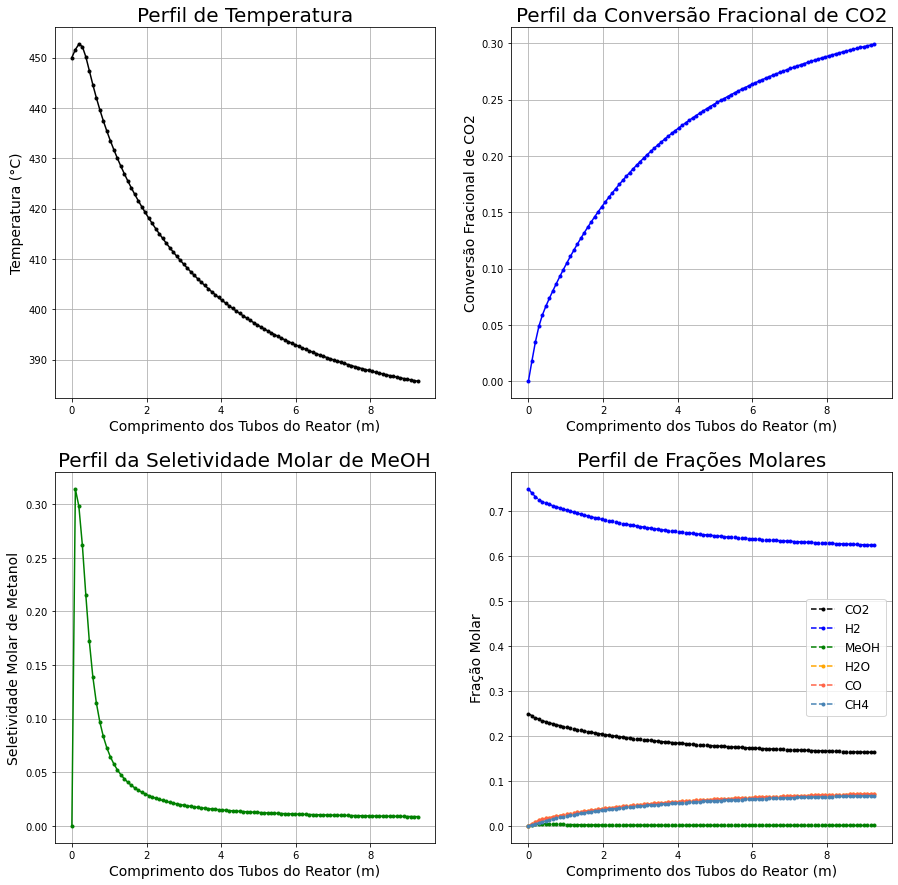

In [35]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(2,2,1)
ax1.plot(results['x'], results['T_K']-273.15, 'k.-')
ax1.set_xlabel('Comprimento dos Tubos do Reator (m)', size = 14)
ax1.set_ylabel('Temperatura (°C)', size= 14)
ax1.set_title('Perfil de Temperatura', size = 20)
ax1.grid()

ax2 = fig.add_subplot(2,2,2)
ax2.plot(results['x'], results['X_CO2'], 'b.-')
ax2.set_xlabel('Comprimento dos Tubos do Reator (m)', size = 14)
ax2.set_ylabel('Conversão Fracional de CO2', size= 14)
ax2.set_title('Perfil da Conversão Fracional de CO2', size = 20)
ax2.grid()

ax3 = fig.add_subplot(2,2,3)
ax3.plot(results['x'], results['S_MeOH'], 'g.-')
ax3.set_xlabel('Comprimento dos Tubos do Reator (m)', size = 14)
ax3.set_ylabel('Seletividade Molar de Metanol', size= 14)
ax3.set_title('Perfil da Seletividade Molar de MeOH', size = 20)
ax3.grid()

comp_list = ['CO2', 'H2', 'MeOH', 'H2O', 'CO', 'CH4']
colors = ['black', 'blue', 'green', 'orange', 'tomato', 'steelblue']

ax4 = fig.add_subplot(2,2,4)
for i in range(len(comp_list)):
    ax4.plot(results['x'], results['y_'+comp_list[i]], '.--', color = colors[i], label = comp_list[i])
ax4.set_xlabel('Comprimento dos Tubos do Reator (m)', size = 14)
ax4.set_ylabel('Fração Molar', size= 14)
ax4.set_title('Perfil de Frações Molares', size = 20)
ax4.legend(prop={'size': 12})
ax4.grid()

In [5]:
T = np.arange(200, 605, 5)
P = np.linspace(10, 50, 3)

results_df = pd.DataFrame(columns = ['T', 'P', 'X_CO2', 'S_MeOH'])
i = 0 
for t in T:
    for p in P:
        cond_dictionary = {
            'T': t, 
            'P': p, 
            'ratio_H2_CO2': 3, 
            'spatial_velocity': 500, 
            'reactor_total_volume': 100, 
            'reactor_LtoD_ratio': 25, 
            'number_of_tubes': 100}
        sim_r = sim.simulate_reactor(cond_dictionary, data_dict, reaction_data)
        x = (sim_r.loc[0, 'F_CO2'] - sim_r.loc[sim_r.shape[0]-1, 'F_CO2'])/sim_r.loc[0, 'F_CO2']
        s = sim_r.loc[sim_r.shape[0]-1, 'F_MeOH']/(sim_r.loc[sim_r.shape[0]-1, 'F_CO'] + sim_r.loc[sim_r.shape[0]-1, 'F_CH4'])
        results_df.loc[i, ['T', 'P', 'X_CO2', 'S_MeOH']] = t, p, x, s
        i += 1
results_df

,T,P,X_CO2,S_MeOH
0,200,10.0,0.004234,0.530024
1,200,30.0,0.001861,0.667829
2,200,50.0,0.001214,0.723705
3,205,10.0,0.005251,0.517779
4,205,30.0,0.002334,0.656776
...,...,...,...,...
238,595,30.0,-0.910118,1.54949
239,595,50.0,-0.624829,1.652167
240,600,10.0,NaN,NaN
241,600,30.0,-0.909006,1.590929


In [11]:
results_df = results_df[(results_df['X_CO2']>0) & (results_df['S_MeOH']>0)]
results_df

,T,P,X_CO2,S_MeOH
0,200,10.0,0.004234,0.530024
1,200,30.0,0.001861,0.667829
2,200,50.0,0.001214,0.723705
3,205,10.0,0.005251,0.517779
4,205,30.0,0.002334,0.656776
...,...,...,...,...
179,495,50.0,0.370224,0.004212
182,500,50.0,0.377693,0.003712
185,505,50.0,0.384872,0.003275
191,515,50.0,0.412399,0.019401


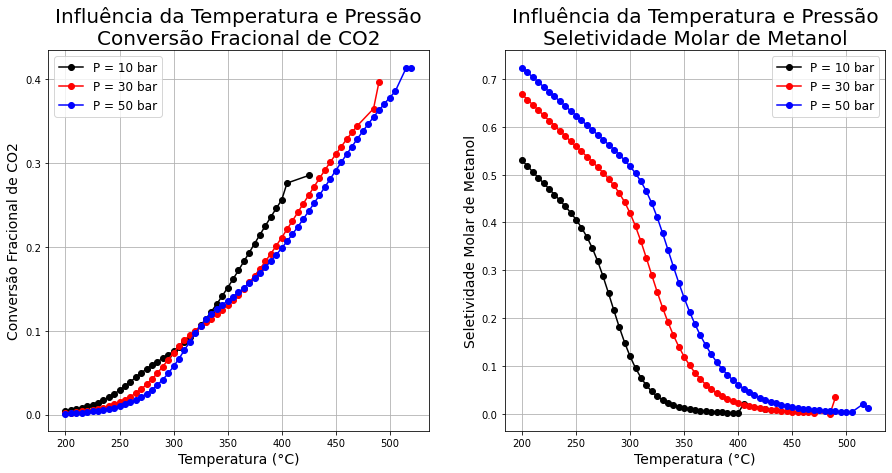

In [17]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,2,1)
ax.plot(results_df.loc[results_df['P']==10, 'T'], results_df.loc[results_df['P']==10, 'X_CO2'], 'ko-', label = 'P = 10 bar')
ax.plot(results_df.loc[results_df['P']==30, 'T'], results_df.loc[results_df['P']==30, 'X_CO2'], 'ro-', label = 'P = 30 bar')
ax.plot(results_df.loc[results_df['P']==50, 'T'], results_df.loc[results_df['P']==50, 'X_CO2'], 'bo-', label = 'P = 50 bar')
ax.set_xlabel('Temperatura (°C)', size = 14)
ax.set_ylabel('Conversão Fracional de CO2', size = 14)
ax.legend(prop={'size':12})
ax.set_title('Influência da Temperatura e Pressão\nConversão Fracional de CO2', size = 20)
ax.grid()

ax2 = fig.add_subplot(1,2,2)
ax2.plot(results_df.loc[results_df['P']==10, 'T'], results_df.loc[results_df['P']==10, 'S_MeOH'], 'ko-', label = 'P = 10 bar')
ax2.plot(results_df.loc[results_df['P']==30, 'T'], results_df.loc[results_df['P']==30, 'S_MeOH'], 'ro-', label = 'P = 30 bar')
ax2.plot(results_df.loc[results_df['P']==50, 'T'], results_df.loc[results_df['P']==50, 'S_MeOH'], 'bo-', label = 'P = 50 bar')
ax2.set_xlabel('Temperatura (°C)', size = 14)
ax2.set_ylabel('Seletividade Molar de Metanol', size = 14)
ax2.legend(prop={'size':12})
ax2.set_title('Influência da Temperatura e Pressão\nSeletividade Molar de Metanol', size = 20)
ax2.grid()